# **Car Body Damage Detection**
### -Detect scratch, dent, repaint etc. on car body

### Source/Useful Links

For Segmentation: https://www.tensorflow.org/tutorials/images/segmentation

U-net - https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

Data Preprocessing:
1. https://towardsdatascience.com/cnn-application-detecting-car-exterior-damage-full-implementable-code-1b205e3cb48c

2. https://www.analyticsvidhya.com/blog/2018/07/building-mask-r-cnn-model-detecting-damage-cars-python/

Training and predictions: 
Google Colab https://colab.research.google.com/

In [0]:
# Using segmentation_models for image segmentation task, https://github.com/qubvel/segmentation_models
! pip install segmentation-models

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import datetime
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import pathlib
from PIL import Image
import numpy as np
#from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
from datetime import datetime
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from IPython.display import clear_output
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE
from sklearn.model_selection import train_test_split

# for TensorBoard
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x

import segmentation_models
print(segmentation_models.__version__)

import segmentation_models as sm

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/Colab Notebooks/CS2/references/")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join("/content/mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

1.0.1


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 4. **Data preparation**

In [0]:
def display1(display_list):
  plt.figure(figsize=(8, 8))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [0]:
def create_mask(pred_mask):
  '''
  as predicted mask has 4dim with bacth size we need to remove that
  tf.argmax Returns the index with the largest value across axes of a tensor.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [0]:
def show_predictions(dataset=None, num=3):
  '''
  Takes input image and predicts mask and plots the Input, True, Predicted images
  '''
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display1([image[0], mask[0], create_mask(pred_mask)])
  else:
    display1([sample_image, sample_mask,
             model.predict(sample_image[tf.newaxis, ...])[0]])

### Tfdata Generator

In [0]:
TRAIN_LENGTH = 49
BATCH_SIZE = 8
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
OUTPUT_CHANNELS = 3

In [0]:
data_root = pathlib.Path("/content/drive/My Drive/Colab Notebooks/CS2/references/new")
val_data_root = pathlib.Path("/content/drive/My Drive/Colab Notebooks/CS2/references/new")
print(val_data_root)

/content/drive/My Drive/Colab Notebooks/CS2/references/new


In [0]:
##Getting all image paths
import random

all_image_paths = list(data_root.glob('images/*/*'))
all_image_paths = [str(path) for path in all_image_paths]

all_mask_paths = list(data_root.glob('masks/*/*'))
all_mask_paths = [str(path) for path in all_mask_paths]

val_all_image_paths = list(data_root.glob('v_images/*/*'))
val_all_image_paths = [str(path) for path in val_all_image_paths]

val_all_mask_paths = list(data_root.glob('v_masks/*/*'))
val_all_mask_paths = [str(path) for path in val_all_mask_paths]

# ##shuffling the images 
# random.shuffle(all_image_paths)

print("image_count = ", len(all_image_paths), ", mask_count = ", len(all_mask_paths))
print("val_image_count = ", len(val_all_image_paths), ", val_mask_count = ", len(val_all_mask_paths))

image_count =  43 , mask_count =  43
val_image_count =  5 , val_mask_count =  5


In [0]:
def tfdata_generator(images, mask, is_training, batch_size=1):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename, mask):
        #reading path 
        image_string = tf.io.read_file(filename)
        mask_string = tf.io.read_file(mask)
        
        #decoding image
        image = tf.image.decode_jpeg(image_string, channels=3)
        mask = tf.image.decode_jpeg(mask_string, channels=3)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        
        #resize the image
        image = tf.image.resize(image, [256, 256])
        mask = tf.image.resize(mask, [256, 256])
        
        image = tf.image.resize_with_crop_or_pad(image, 300, 300) # Add 6 pixels of padding
        image = tf.image.random_crop(image, size=[256, 256, 3], seed = 1) # Random crop back to 256X256
        #image = tf.image.random_brightness(image, max_delta=0.5, seed = 1)
        image = tf.image.random_flip_left_right(image, seed=1)
        image = tf.image.random_flip_up_down(image, seed=1)
        #image = tf.image.random_jpeg_quality(image, 90, 100, seed=1)

        mask = tf.image.resize_with_crop_or_pad(mask, 300, 300) # Add 6 pixels of padding
        mask = tf.image.random_crop(mask, size=[256, 256, 3], seed = 1) # Random crop back to 256X256
        #mask = tf.image.random_brightness(mask, max_delta=0.5, seed = 1)
        mask = tf.image.random_flip_left_right(mask, seed=1)
        mask = tf.image.random_flip_up_down(mask, seed=1)
        #mask = tf.image.random_jpeg_quality(mask, 90, 100, seed=1)

        #image, mask = normalize(image, mask)
        return image, mask
    
    ##creating a dataset from tensorslices
    dataset = tf.data.Dataset.from_tensor_slices((images, mask))
    
    if is_training:
        dataset = dataset.shuffle(100)  # depends on sample size

    # Transform and batch data at the same time
    dataset = dataset.apply(tf.data.experimental.map_and_batch( parse_function, batch_size, num_parallel_batches=32,  # cpu cores
        drop_remainder=True if is_training else False))
    
    #repeat the dataset indefinitely
    dataset = dataset.repeat()

    
    #prefetch the data into CPU/GPU
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset


In [0]:
#creating a generator
tf_image_generator = tfdata_generator(all_image_paths, all_mask_paths, is_training=True, batch_size=8)
val_tf_image_generator = tfdata_generator(val_all_image_paths, val_all_mask_paths, is_training=True, batch_size=4)
tf_image_generator

<PrefetchDataset shapes: ((8, 256, 256, 3), (8, 256, 256, 3)), types: (tf.float32, tf.float32)>

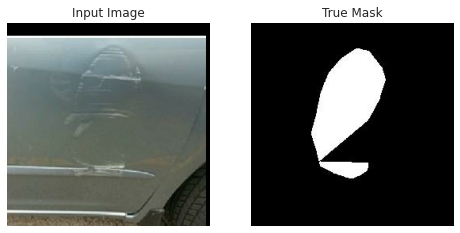

In [0]:
for image, mask in val_tf_image_generator.take(5):
  sample_image, sample_mask = image[0], mask[0]
display1([sample_image, sample_mask])

## 5. Define Custom model

<img src="images/U_net.PNG">

In [0]:
#https://github.com/ToddTheWraith/examples/tree/5507f1f2f3d5935865d64e1789f367db208ca41b/community/en
#https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

# Modified u-net model

tf.keras.backend.clear_session()
class EncoderBlock(tf.keras.Model):
  def __init__(self, filter_size):
    # initilize instance variables
    super(EncoderBlock, self).__init__()
    self.filter_size = filter_size
    # define layers
    self.layer_1 = layers.Activation('relu')
    self.layer_2 = layers.SeparableConv2D(self.filter_size, 3, padding='same')
    self.layer_3 = layers.BatchNormalization()

    self.layer_4 = layers.Activation('relu')
    self.layer_5 = layers.SeparableConv2D(self.filter_size, 3, padding='same')
    self.layer_6 = layers.BatchNormalization()

    self.layer_7 = layers.MaxPooling2D(3, strides=2, padding='same')

    # project residual
    self.residual_layer = layers.Conv2D(self.filter_size, 1, strides=2, padding='same')
  def call(self, inputs):
    x = self.layer_1(inputs)
    x = self.layer_2(x)
    x = self.layer_3(x)
    x = self.layer_4(x)
    x = self.layer_5(x)
    x = self.layer_6(x)
    x = self.layer_7(x)
    residual = self.residual_layer(inputs)
    x = layers.add([x, residual])
    return x

class DecoderBlock(tf.keras.Model):
  def __init__(self, filter_size):
    # initilize instance variables
    super(DecoderBlock, self).__init__()
    self.filter_size = filter_size
    # define layers
    self.layer_1 = layers.Activation('relu')
    self.layer_2 = layers.Conv2DTranspose(self.filter_size, 3, padding='same')
    self.layer_3 = layers.BatchNormalization()

    self.layer_4 = layers.Activation('relu')
    self.layer_5 = layers.Conv2DTranspose(self.filter_size, 3, padding='same')
    self.layer_6 = layers.BatchNormalization()

    self.layer_7 = layers.UpSampling2D(2)

    # project residual
    self.residual_layer_1 = layers.UpSampling2D(2)
    self.residual_layer_2 = layers.Conv2D(filter_size, 1, padding='same')
  def call(self, inputs):
    x = self.layer_1(inputs)
    x = self.layer_2(x)
    x = self.layer_3(x)
    x = self.layer_4(x)
    x = self.layer_5(x)
    x = self.layer_6(x)
    x = self.layer_7(x)
    residual = self.residual_layer_1(inputs)
    residual = self.residual_layer_2(residual)

    x = layers.add([x, residual])
    return x

In [0]:
class UnetModel(tf.keras.Model):
  def __init__(self, output_channels, dynamic=True):
    # initilize instance variables
    super(UnetModel, self).__init__()
    self.output_channels = output_channels

    self.entry_block_1 = layers.Conv2D(32, 3, strides=2, padding='same')
    self.entry_block_2 = layers.BatchNormalization()
    self.entry_block_3 = layers.Activation('relu')

    self.encoder_block_1 = EncoderBlock(64)
    self.encoder_block_2 = EncoderBlock(128)
    self.encoder_block_3 = EncoderBlock(256)

    self.decoder_block_1 = DecoderBlock(256)
    self.decoder_block_2 = DecoderBlock(128)
    self.decoder_block_3 = DecoderBlock(64)
    self.decoder_block_4 = DecoderBlock(32)

    self.output_layer = layers.Conv2D(
        output_channels, 3, activation='sigmoid', padding='same')
    
  def call(self, inputs):
    x = self.entry_block_1(inputs)
    x = self.entry_block_2(x)
    x = self.entry_block_3(x)
    x = self.encoder_block_1(x)
    x = self.encoder_block_2(x)
    x = self.encoder_block_3(x)
    x = self.decoder_block_1(x)
    x = self.decoder_block_2(x)
    x = self.decoder_block_3(x)
    x = self.decoder_block_4(x)
    x = self.output_layer(x)
    return x

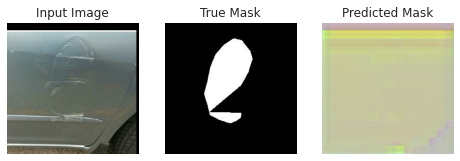

Model: "unet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
encoder_block (EncoderBlock) multiple                  9760      
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  35904     
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  137344    
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  1

In [0]:
tf.keras.backend.clear_session()
model = UnetModel(3)
model.compile()
show_predictions()
model.summary()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  '''
  To check the predicted mask at each epoch
  '''
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [0]:
# Metrics
# For image segmentation
# COMPETITION METRIC
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate
def dice_coef(y_true, y_pred, smooth=K.epsilon()):
    '''
    This function returns dice coefficient of similarity between y_true and y_pred
    Dice coefficient is also referred to as F1_score, but we will use this name for image segmentation models
    For example, 
    let an instance on y_true and y_pred be [[1,1],[0,1]] and [[1,0],[0,1]]
    this metric first converts the above into [1,1,0,1] abd [1,0,0,1],
    then intersection is calculated as 1*1 + 1*0 + 0*1 + 1*1 = 2 and sum(y_true)+sum(y_pred)= 3+2 = 5
    this returns the value (2.* 2 + 10e-7)/(3 + 2 + 10e-7) ~ 0.8    
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
dependencies = {'dice_coef':dice_coef,
    'dice_loss':sm.losses.dice_loss }

### Compile and fit the model

In [0]:
# https://www.tensorflow.org/tensorboard/r2/scalars_and_keras
logdir = '/content/' + datetime.now().strftime("%Y%m%d-%H%M%S")+'_damage_2020'
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=0,write_images=True)
#train_writer = tf.summary.create_file_writer('./logs/1/train')
# https://keras.io/callbacks/
mc = ModelCheckpoint(filepath = ROOT_DIR +'/car_damage_new.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=10)

In [0]:
model = UnetModel(OUTPUT_CHANNELS)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=sm.losses.dice_loss, metrics=[dice_coef])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 0.6731 - dice_coef: 0.3229

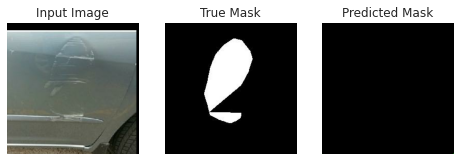


Sample Prediction after epoch 1


Epoch 00001: val_dice_coef improved from -inf to 0.00000, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 20s 406ms/step - loss: 0.6731 - dice_coef: 0.3229 - val_loss: 1.0000 - val_dice_coef: 1.0825e-10
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 0.4687 - dice_coef: 0.5313

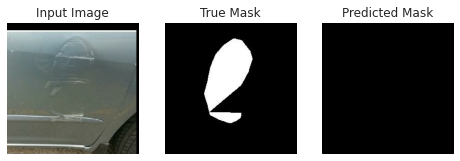


Sample Prediction after epoch 2


Epoch 00002: val_dice_coef did not improve from 0.00000
49/49 [==============================] - 18s 361ms/step - loss: 0.4687 - dice_coef: 0.5313 - val_loss: 1.0000 - val_dice_coef: 8.4207e-13
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.3598 - dice_coef: 0.6402

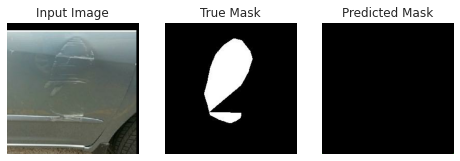


Sample Prediction after epoch 3


Epoch 00003: val_dice_coef did not improve from 0.00000
49/49 [==============================] - 18s 358ms/step - loss: 0.3598 - dice_coef: 0.6402 - val_loss: 1.0000 - val_dice_coef: 9.8082e-13
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.3362 - dice_coef: 0.6638

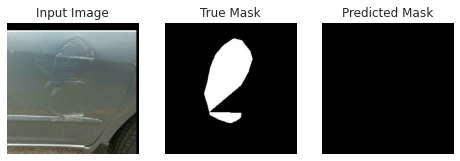


Sample Prediction after epoch 4


Epoch 00004: val_dice_coef did not improve from 0.00000
49/49 [==============================] - 18s 358ms/step - loss: 0.3362 - dice_coef: 0.6638 - val_loss: 1.0000 - val_dice_coef: 9.5003e-13
Epoch 5/50
49/49 [==============================] - ETA: 0s - loss: 0.3085 - dice_coef: 0.6915

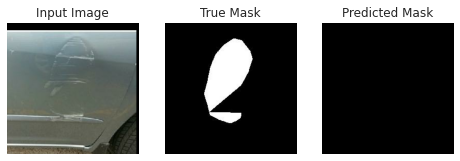


Sample Prediction after epoch 5


Epoch 00005: val_dice_coef did not improve from 0.00000
49/49 [==============================] - 18s 361ms/step - loss: 0.3085 - dice_coef: 0.6915 - val_loss: 1.0000 - val_dice_coef: 9.5009e-13
Epoch 6/50
49/49 [==============================] - ETA: 0s - loss: 0.2639 - dice_coef: 0.7361

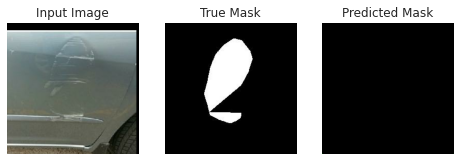


Sample Prediction after epoch 6


Epoch 00006: val_dice_coef did not improve from 0.00000
49/49 [==============================] - 18s 358ms/step - loss: 0.2639 - dice_coef: 0.7361 - val_loss: 1.0000 - val_dice_coef: 9.5003e-13
Epoch 7/50
49/49 [==============================] - ETA: 0s - loss: 0.2833 - dice_coef: 0.7167

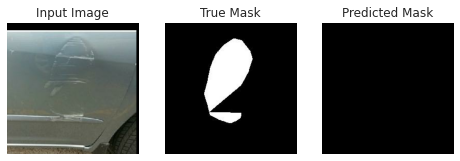


Sample Prediction after epoch 7


Epoch 00007: val_dice_coef did not improve from 0.00000
49/49 [==============================] - 17s 356ms/step - loss: 0.2833 - dice_coef: 0.7167 - val_loss: 1.0000 - val_dice_coef: 8.4207e-13
Epoch 8/50
49/49 [==============================] - ETA: 0s - loss: 0.2764 - dice_coef: 0.7236

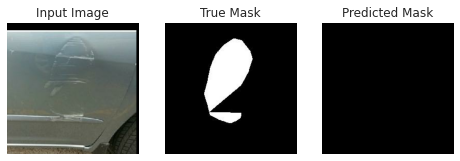


Sample Prediction after epoch 8


Epoch 00008: val_dice_coef did not improve from 0.00000
49/49 [==============================] - 18s 362ms/step - loss: 0.2764 - dice_coef: 0.7236 - val_loss: 1.0000 - val_dice_coef: 9.5016e-13
Epoch 9/50
49/49 [==============================] - ETA: 0s - loss: 0.2375 - dice_coef: 0.7625

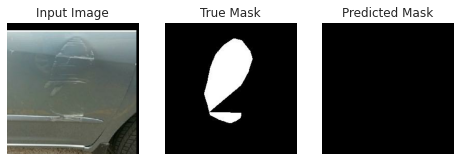


Sample Prediction after epoch 9


Epoch 00009: val_dice_coef did not improve from 0.00000
49/49 [==============================] - 18s 360ms/step - loss: 0.2375 - dice_coef: 0.7625 - val_loss: 1.0000 - val_dice_coef: 1.6074e-12
Epoch 10/50
49/49 [==============================] - ETA: 0s - loss: 0.2501 - dice_coef: 0.7499

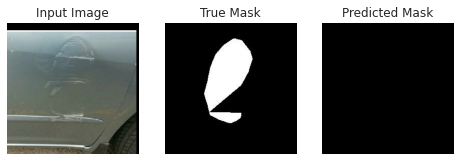


Sample Prediction after epoch 10


Epoch 00010: val_dice_coef improved from 0.00000 to 0.16224, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 18s 371ms/step - loss: 0.2501 - dice_coef: 0.7499 - val_loss: 0.8378 - val_dice_coef: 0.1622
Epoch 11/50
49/49 [==============================] - ETA: 0s - loss: 0.2030 - dice_coef: 0.7970

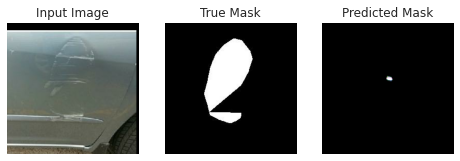


Sample Prediction after epoch 11


Epoch 00011: val_dice_coef improved from 0.16224 to 0.51386, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 18s 360ms/step - loss: 0.2030 - dice_coef: 0.7970 - val_loss: 0.4861 - val_dice_coef: 0.5139
Epoch 12/50
49/49 [==============================] - ETA: 0s - loss: 0.2127 - dice_coef: 0.7873

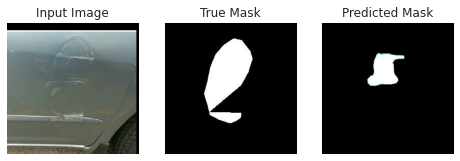


Sample Prediction after epoch 12


Epoch 00012: val_dice_coef did not improve from 0.51386
49/49 [==============================] - 17s 357ms/step - loss: 0.2127 - dice_coef: 0.7873 - val_loss: 0.6173 - val_dice_coef: 0.3827
Epoch 13/50
49/49 [==============================] - ETA: 0s - loss: 0.1815 - dice_coef: 0.8185

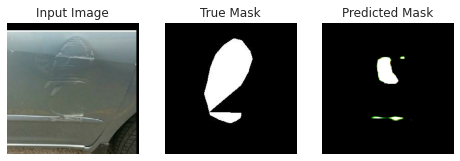


Sample Prediction after epoch 13


Epoch 00013: val_dice_coef improved from 0.51386 to 0.60737, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 18s 366ms/step - loss: 0.1815 - dice_coef: 0.8185 - val_loss: 0.3926 - val_dice_coef: 0.6074
Epoch 14/50
49/49 [==============================] - ETA: 0s - loss: 0.1650 - dice_coef: 0.8350

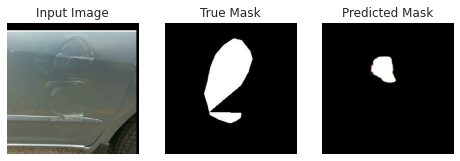


Sample Prediction after epoch 14


Epoch 00014: val_dice_coef did not improve from 0.60737
49/49 [==============================] - 18s 359ms/step - loss: 0.1650 - dice_coef: 0.8350 - val_loss: 0.7851 - val_dice_coef: 0.2150
Epoch 15/50
49/49 [==============================] - ETA: 0s - loss: 0.2070 - dice_coef: 0.7930

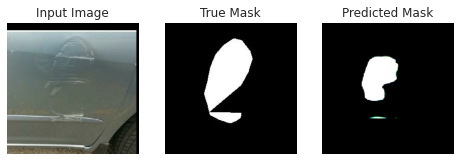


Sample Prediction after epoch 15


Epoch 00015: val_dice_coef improved from 0.60737 to 0.61480, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 18s 371ms/step - loss: 0.2070 - dice_coef: 0.7930 - val_loss: 0.3852 - val_dice_coef: 0.6148
Epoch 16/50
49/49 [==============================] - ETA: 0s - loss: 0.1753 - dice_coef: 0.8247

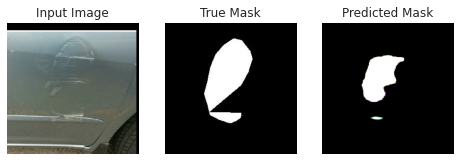


Sample Prediction after epoch 16


Epoch 00016: val_dice_coef did not improve from 0.61480
49/49 [==============================] - 17s 357ms/step - loss: 0.1753 - dice_coef: 0.8247 - val_loss: 0.8009 - val_dice_coef: 0.1991
Epoch 17/50
49/49 [==============================] - ETA: 0s - loss: 0.1750 - dice_coef: 0.8250

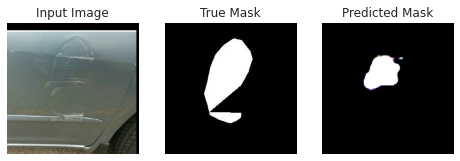


Sample Prediction after epoch 17


Epoch 00017: val_dice_coef did not improve from 0.61480
49/49 [==============================] - 18s 360ms/step - loss: 0.1750 - dice_coef: 0.8250 - val_loss: 0.6999 - val_dice_coef: 0.3001
Epoch 18/50
49/49 [==============================] - ETA: 0s - loss: 0.1928 - dice_coef: 0.8072

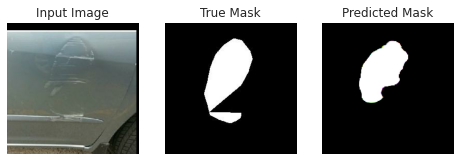


Sample Prediction after epoch 18


Epoch 00018: val_dice_coef did not improve from 0.61480
49/49 [==============================] - 17s 356ms/step - loss: 0.1928 - dice_coef: 0.8072 - val_loss: 0.4884 - val_dice_coef: 0.5116
Epoch 19/50
49/49 [==============================] - ETA: 0s - loss: 0.1879 - dice_coef: 0.8121

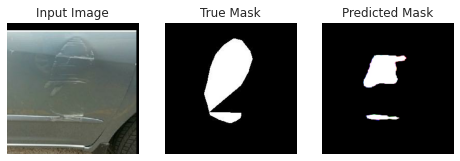


Sample Prediction after epoch 19


Epoch 00019: val_dice_coef did not improve from 0.61480
49/49 [==============================] - 18s 369ms/step - loss: 0.1879 - dice_coef: 0.8121 - val_loss: 0.4667 - val_dice_coef: 0.5333
Epoch 20/50
49/49 [==============================] - ETA: 0s - loss: 0.2048 - dice_coef: 0.7952

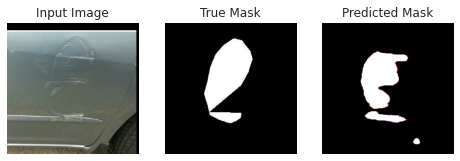


Sample Prediction after epoch 20


Epoch 00020: val_dice_coef improved from 0.61480 to 0.63782, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 18s 365ms/step - loss: 0.2048 - dice_coef: 0.7952 - val_loss: 0.3622 - val_dice_coef: 0.6378
Epoch 21/50
49/49 [==============================] - ETA: 0s - loss: 0.1537 - dice_coef: 0.8463

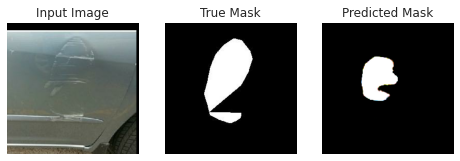


Sample Prediction after epoch 21


Epoch 00021: val_dice_coef did not improve from 0.63782
49/49 [==============================] - 17s 354ms/step - loss: 0.1537 - dice_coef: 0.8463 - val_loss: 0.4233 - val_dice_coef: 0.5767
Epoch 22/50
49/49 [==============================] - ETA: 0s - loss: 0.1531 - dice_coef: 0.8469

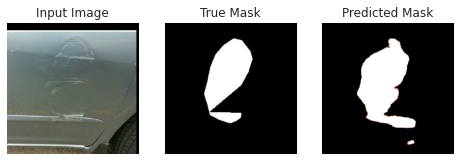


Sample Prediction after epoch 22


Epoch 00022: val_dice_coef did not improve from 0.63782
49/49 [==============================] - 18s 359ms/step - loss: 0.1531 - dice_coef: 0.8469 - val_loss: 0.3947 - val_dice_coef: 0.6053
Epoch 23/50
49/49 [==============================] - ETA: 0s - loss: 0.1481 - dice_coef: 0.8519

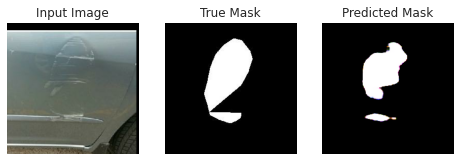


Sample Prediction after epoch 23


Epoch 00023: val_dice_coef did not improve from 0.63782
49/49 [==============================] - 18s 358ms/step - loss: 0.1481 - dice_coef: 0.8519 - val_loss: 0.6112 - val_dice_coef: 0.3888
Epoch 24/50
49/49 [==============================] - ETA: 0s - loss: 0.1380 - dice_coef: 0.8620

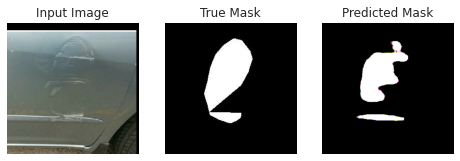


Sample Prediction after epoch 24


Epoch 00024: val_dice_coef did not improve from 0.63782
49/49 [==============================] - 18s 361ms/step - loss: 0.1380 - dice_coef: 0.8620 - val_loss: 0.3886 - val_dice_coef: 0.6114
Epoch 25/50
49/49 [==============================] - ETA: 0s - loss: 0.1345 - dice_coef: 0.8655

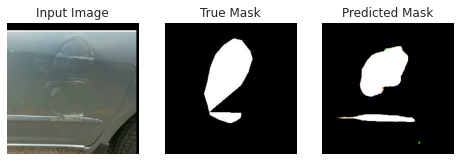


Sample Prediction after epoch 25


Epoch 00025: val_dice_coef improved from 0.63782 to 0.71494, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 18s 376ms/step - loss: 0.1345 - dice_coef: 0.8655 - val_loss: 0.2851 - val_dice_coef: 0.7149
Epoch 26/50
49/49 [==============================] - ETA: 0s - loss: 0.1399 - dice_coef: 0.8601

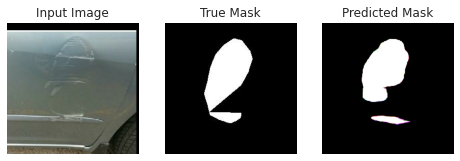


Sample Prediction after epoch 26


Epoch 00026: val_dice_coef did not improve from 0.71494
49/49 [==============================] - 19s 378ms/step - loss: 0.1399 - dice_coef: 0.8601 - val_loss: 0.4079 - val_dice_coef: 0.5921
Epoch 27/50
49/49 [==============================] - ETA: 0s - loss: 0.1382 - dice_coef: 0.8618

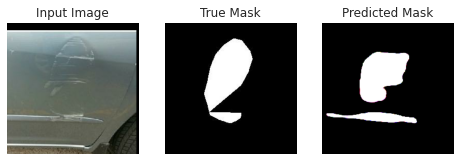


Sample Prediction after epoch 27


Epoch 00027: val_dice_coef did not improve from 0.71494
49/49 [==============================] - 18s 358ms/step - loss: 0.1382 - dice_coef: 0.8618 - val_loss: 0.4422 - val_dice_coef: 0.5578
Epoch 28/50
49/49 [==============================] - ETA: 0s - loss: 0.1993 - dice_coef: 0.8007

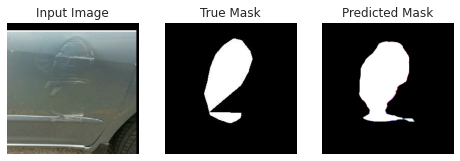


Sample Prediction after epoch 28


Epoch 00028: val_dice_coef improved from 0.71494 to 0.72862, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 18s 368ms/step - loss: 0.1993 - dice_coef: 0.8007 - val_loss: 0.2714 - val_dice_coef: 0.7286
Epoch 29/50
49/49 [==============================] - ETA: 0s - loss: 0.1904 - dice_coef: 0.8096

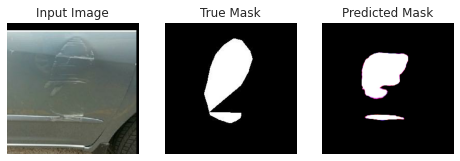


Sample Prediction after epoch 29


Epoch 00029: val_dice_coef did not improve from 0.72862
49/49 [==============================] - 17s 355ms/step - loss: 0.1904 - dice_coef: 0.8096 - val_loss: 0.4154 - val_dice_coef: 0.5846
Epoch 30/50
49/49 [==============================] - ETA: 0s - loss: 0.1852 - dice_coef: 0.8148

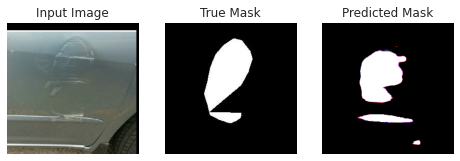


Sample Prediction after epoch 30


Epoch 00030: val_dice_coef did not improve from 0.72862
49/49 [==============================] - 17s 353ms/step - loss: 0.1852 - dice_coef: 0.8148 - val_loss: 0.2962 - val_dice_coef: 0.7038
Epoch 31/50
49/49 [==============================] - ETA: 0s - loss: 0.1775 - dice_coef: 0.8225

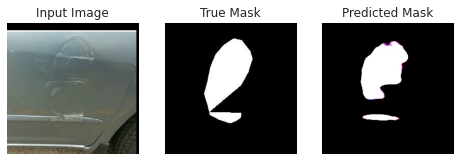


Sample Prediction after epoch 31


Epoch 00031: val_dice_coef did not improve from 0.72862
49/49 [==============================] - 17s 357ms/step - loss: 0.1775 - dice_coef: 0.8225 - val_loss: 0.3416 - val_dice_coef: 0.6584
Epoch 32/50
49/49 [==============================] - ETA: 0s - loss: 0.1729 - dice_coef: 0.8271

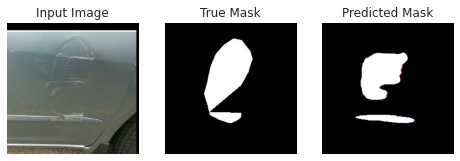


Sample Prediction after epoch 32


Epoch 00032: val_dice_coef did not improve from 0.72862
49/49 [==============================] - 17s 354ms/step - loss: 0.1729 - dice_coef: 0.8271 - val_loss: 0.3079 - val_dice_coef: 0.6921
Epoch 33/50
49/49 [==============================] - ETA: 0s - loss: 0.1903 - dice_coef: 0.8097

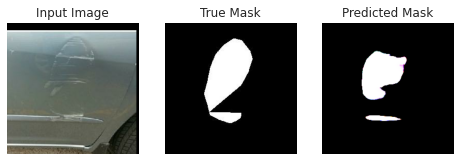


Sample Prediction after epoch 33


Epoch 00033: val_dice_coef did not improve from 0.72862
49/49 [==============================] - 17s 357ms/step - loss: 0.1903 - dice_coef: 0.8097 - val_loss: 0.3007 - val_dice_coef: 0.6993
Epoch 34/50
49/49 [==============================] - ETA: 0s - loss: 0.1228 - dice_coef: 0.8772

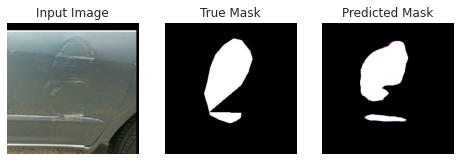


Sample Prediction after epoch 34


Epoch 00034: val_dice_coef improved from 0.72862 to 0.76054, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 18s 365ms/step - loss: 0.1228 - dice_coef: 0.8772 - val_loss: 0.2395 - val_dice_coef: 0.7605
Epoch 35/50
49/49 [==============================] - ETA: 0s - loss: 0.1197 - dice_coef: 0.8803

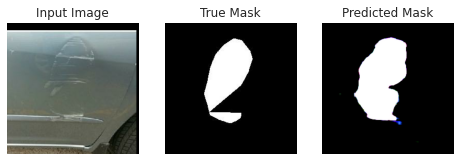


Sample Prediction after epoch 35


Epoch 00035: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 18s 359ms/step - loss: 0.1197 - dice_coef: 0.8803 - val_loss: 0.3377 - val_dice_coef: 0.6623
Epoch 36/50
49/49 [==============================] - ETA: 0s - loss: 0.1522 - dice_coef: 0.8478

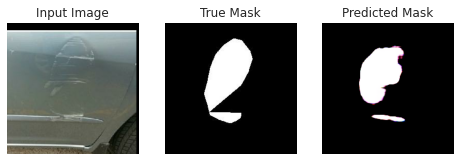


Sample Prediction after epoch 36


Epoch 00036: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 17s 355ms/step - loss: 0.1522 - dice_coef: 0.8478 - val_loss: 0.3535 - val_dice_coef: 0.6465
Epoch 37/50
49/49 [==============================] - ETA: 0s - loss: 0.1707 - dice_coef: 0.8293

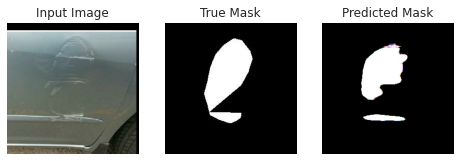


Sample Prediction after epoch 37


Epoch 00037: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 17s 353ms/step - loss: 0.1707 - dice_coef: 0.8293 - val_loss: 0.3453 - val_dice_coef: 0.6547
Epoch 38/50
49/49 [==============================] - ETA: 0s - loss: 0.1650 - dice_coef: 0.8350

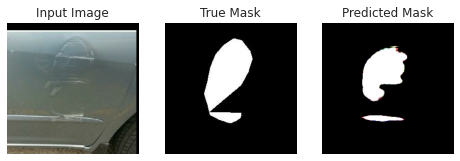


Sample Prediction after epoch 38


Epoch 00038: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 18s 359ms/step - loss: 0.1650 - dice_coef: 0.8350 - val_loss: 0.3956 - val_dice_coef: 0.6044
Epoch 39/50
49/49 [==============================] - ETA: 0s - loss: 0.1620 - dice_coef: 0.8380

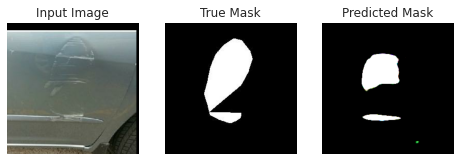


Sample Prediction after epoch 39


Epoch 00039: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 18s 359ms/step - loss: 0.1620 - dice_coef: 0.8380 - val_loss: 0.5101 - val_dice_coef: 0.4899
Epoch 40/50
49/49 [==============================] - ETA: 0s - loss: 0.2446 - dice_coef: 0.7554

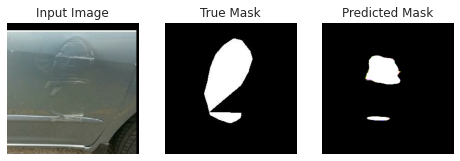


Sample Prediction after epoch 40


Epoch 00040: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 18s 357ms/step - loss: 0.2446 - dice_coef: 0.7554 - val_loss: 0.4600 - val_dice_coef: 0.5400
Epoch 41/50
49/49 [==============================] - ETA: 0s - loss: 0.2178 - dice_coef: 0.7822

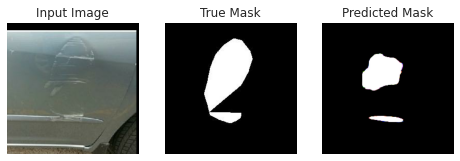


Sample Prediction after epoch 41


Epoch 00041: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 18s 357ms/step - loss: 0.2178 - dice_coef: 0.7822 - val_loss: 0.3984 - val_dice_coef: 0.6016
Epoch 42/50
49/49 [==============================] - ETA: 0s - loss: 0.2190 - dice_coef: 0.7810

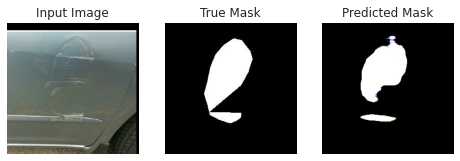


Sample Prediction after epoch 42


Epoch 00042: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 17s 354ms/step - loss: 0.2190 - dice_coef: 0.7810 - val_loss: 0.4549 - val_dice_coef: 0.5451
Epoch 43/50
49/49 [==============================] - ETA: 0s - loss: 0.1824 - dice_coef: 0.8176

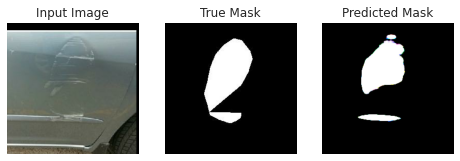


Sample Prediction after epoch 43


Epoch 00043: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 17s 354ms/step - loss: 0.1824 - dice_coef: 0.8176 - val_loss: 0.3152 - val_dice_coef: 0.6848
Epoch 44/50
49/49 [==============================] - ETA: 0s - loss: 0.1443 - dice_coef: 0.8557

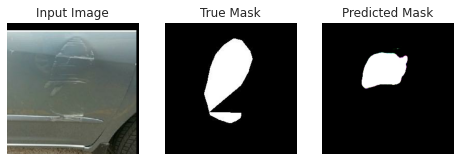


Sample Prediction after epoch 44


Epoch 00044: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 17s 356ms/step - loss: 0.1443 - dice_coef: 0.8557 - val_loss: 0.3165 - val_dice_coef: 0.6835
Epoch 45/50
49/49 [==============================] - ETA: 0s - loss: 0.1634 - dice_coef: 0.8366

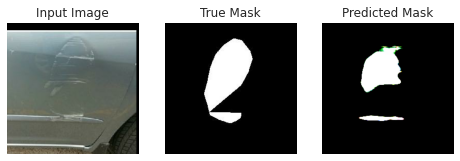


Sample Prediction after epoch 45


Epoch 00045: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 17s 353ms/step - loss: 0.1634 - dice_coef: 0.8366 - val_loss: 0.4780 - val_dice_coef: 0.5220
Epoch 46/50
49/49 [==============================] - ETA: 0s - loss: 0.1834 - dice_coef: 0.8166

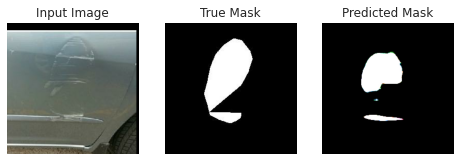


Sample Prediction after epoch 46


Epoch 00046: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 18s 358ms/step - loss: 0.1834 - dice_coef: 0.8166 - val_loss: 0.3908 - val_dice_coef: 0.6092
Epoch 47/50
49/49 [==============================] - ETA: 0s - loss: 0.1914 - dice_coef: 0.8086

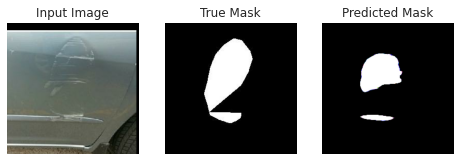


Sample Prediction after epoch 47


Epoch 00047: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 17s 350ms/step - loss: 0.1914 - dice_coef: 0.8086 - val_loss: 0.4526 - val_dice_coef: 0.5474
Epoch 48/50
49/49 [==============================] - ETA: 0s - loss: 0.2165 - dice_coef: 0.7835

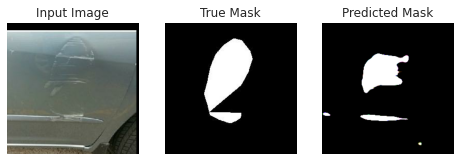


Sample Prediction after epoch 48


Epoch 00048: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 18s 358ms/step - loss: 0.2165 - dice_coef: 0.7835 - val_loss: 0.3302 - val_dice_coef: 0.6698
Epoch 49/50
49/49 [==============================] - ETA: 0s - loss: 0.2054 - dice_coef: 0.7946

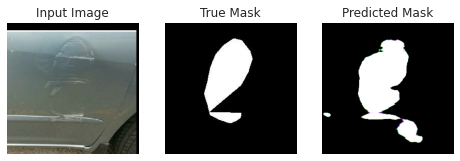


Sample Prediction after epoch 49


Epoch 00049: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 18s 358ms/step - loss: 0.2054 - dice_coef: 0.7946 - val_loss: 0.3211 - val_dice_coef: 0.6789
Epoch 50/50
49/49 [==============================] - ETA: 0s - loss: 0.1671 - dice_coef: 0.8329

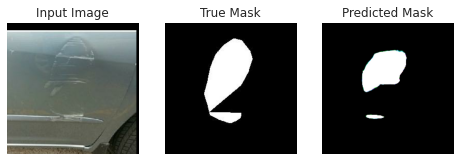


Sample Prediction after epoch 50


Epoch 00050: val_dice_coef did not improve from 0.76054
49/49 [==============================] - 18s 361ms/step - loss: 0.1671 - dice_coef: 0.8329 - val_loss: 0.3511 - val_dice_coef: 0.6489


In [0]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 5//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit_generator(tf_image_generator, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_tf_image_generator,
                          callbacks=[DisplayCallback(), mc, tensorboard])

### Plotting Losses

### TensorBoard

<img src="images/tensorboard_unet_modified.PNG">

Sample predictions



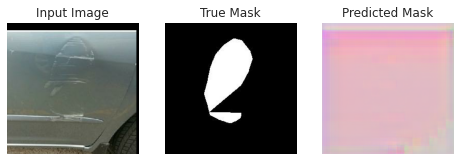

In [0]:
# Loading best model
model = UnetModel(OUTPUT_CHANNELS)
model.compile(optimizer=optimizer, loss=sm.losses.dice_loss, metrics=[dice_coef])
print('Sample predictions\n')
show_predictions()
model.load_weights('/content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5')

In [0]:
# Save the entire model as a SavedModel.
model.save('/content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_final_unet')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_final_unet/assets


In [0]:
model = load_model('/content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_final_unet', custom_objects=dependencies)

## 6. Predictions

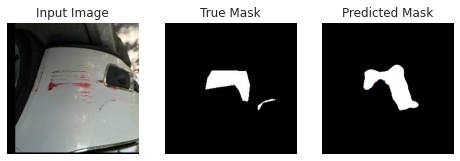

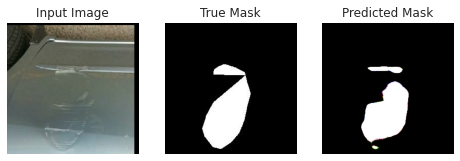

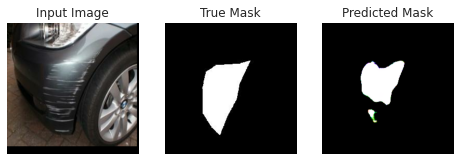

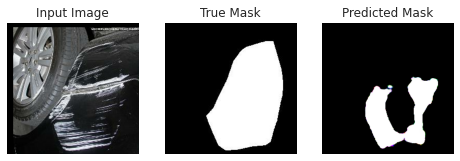

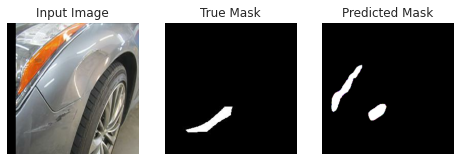

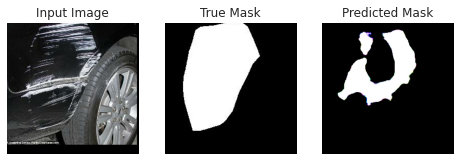

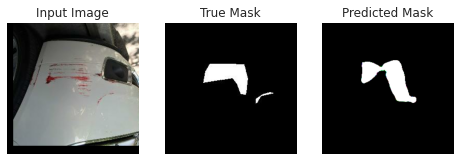

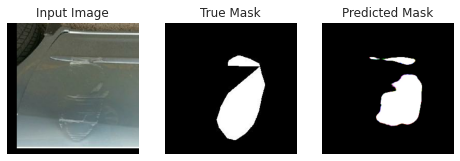

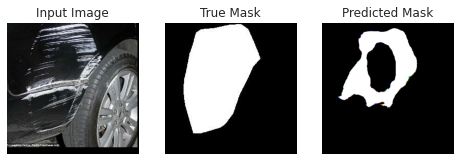

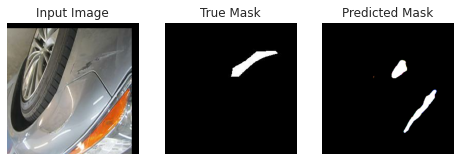

In [0]:
for image, mask in val_tf_image_generator.take(10):
  sample_image, sample_mask = image[0], mask[0]
  display1([sample_image, sample_mask,
         model.predict(sample_image[tf.newaxis, ...])[0]])